# RDF Graph

In [7]:
import datetime
import re

def now_as_xsd_dateTime():
    # Get the current datetime in UTC
    current_time = datetime.utcnow().isoformat()

    # Remove microseconds for compliance
    if '.' in current_time:
        current_time = current_time.split('.')[0]

    # Append the UTC timezone indicator
    current_time += 'Z'

    return current_time

def remove_section_symbol(input_string: str) -> str:
    """
    Removes the '§' symbol from the input string and trims whitespace.

    Args:
        input_string (str): The string from which to remove the '§' symbol.

    Returns:
        str: The cleaned string without the '§' symbol and leading/trailing whitespace.

    Raises:
        TypeError: If 'input_string' is not a string.
    """
    if not isinstance(input_string, str):
        raise TypeError("input_string must be a string")
    return input_string.replace("§", "").strip()

def normalize_ns_string(input_string: str) -> str:
    """
    Transform the input string to title case, which capitalizes the first letter of each word.

    Args:
        input_string (str): The string to normalize.

    Returns:
        normalized_string (str): The normalized string.
    """
    normalized_string = remove_section_symbol(input_string)

    # Remove all spaces, change points and hyphens to underscores
    return normalized_string.replace(" ", "").replace("-", "_").replace(".", "_")

def transform_to_rdf_subject(input_string: str) -> str:
    """
    Transform the input string to a valid RDF subject by converting it to camel case
    and replacing invalid characters.

    Args:
        input_string (str): The string to transform.

    Returns:
        rdf_subject (str): The transformed RDF subject name.
    """
    # Convert to title case (camel case)
    camel_case_string = ''.join(word.capitalize() for word in input_string.split())
    # Replace invalid characters (retain only alphanumeric and underscore)
    rdf_subject = re.sub(r'[^a-zA-Z0-9_]', '', camel_case_string)

    return rdf_subject

In [11]:
normalize_ns_string("275_0_2_P1").replace("_P1", "")

'275_0_2'

In [ ]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS

# Initialize a graph
g = Graph()

# Define a namespace
EX = Namespace("http://example.org/")

# Sample data (simplified for demonstration)
data = {
    "id": normalize_ns_string("275_0_2_P1").replace("_P1", ""),
    "type": "llm_response",
    "content": {
        "section": "\u00a7 275.0-2",
        "summary": "This section outlines the procedures for serving legal documents...",
        "elements": [
            {
                "id": 1,
                "title": "Service of process on non-resident entities",
                "statement": "A person may serve process...",
                "terms": [
                    {"term": "Person", "classification": "Common Noun"},
                    {"term": "Non-resident investment adviser", "classification": "Common Noun"},
                    # More terms...
                ],
                # More fields...
            },
            # More elements...
        ]
    }
}

# Create RDF triples
content_id = URIRef(EX[data["id"]])
g.add((content_id, RDF.type, URIRef(EX[data["type"]])))
g.add((content_id, EX.section, Literal(data["content"]["section"])))
g.add((content_id, EX.summary, Literal(data["content"]["summary"])))

# Add elements
for element in data["content"]["elements"]:
    element_id = URIRef(EX[f"element_{element['id']}"])
    g.add((content_id, EX.hasElement, element_id))
    g.add((element_id, EX.title, Literal(element["title"])))
    g.add((element_id, EX.statement, Literal(element["statement"])))

    # Add terms
    for term in element["terms"]:
        term_id = URIRef(EX[term["term"].replace(" ", "_")])
        g.add((element_id, EX.hasTerm, term_id))
        g.add((term_id, EX.classification, Literal(term["classification"])))

# Serialize the graph
print(g.serialize(format="turtle"))

@prefix ns1: <http://example.org/> .

ns1:275_0_2 a ns1:element ;
    ns1:hasElement ns1:element_1 ;
    ns1:section "§ 275.0-2" ;
    ns1:summary "This section outlines the procedures for serving legal documents..." .

ns1:Non-resident_investment_adviser ns1:classification "Common Noun" .

ns1:Person ns1:classification "Common Noun" .

ns1:element_1 ns1:hasTerm ns1:Non-resident_investment_adviser,
        ns1:Person ;
    ns1:statement "A person may serve process..." ;
    ns1:title "Service of process on non-resident entities" .




In [19]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF

# Initialize a graph
g = Graph()

# Define a namespace
EX = Namespace("http://example.org/")

# Sample data (simplified for demonstration)
data = {
    "id": normalize_ns_string("275_0_2_P1").replace("_P1", ""),
    "type": "llm_response",
    "content": {
        "section": normalize_ns_string("275_0_2_P1").replace("_P1", ""),
        "summary": "This section outlines the procedures for serving legal documents...",
        "elements": [
            {
                "id": 1,
                "title": "Service of process on non-resident entities",
                "statement": "A person may serve process...",
                "terms": [
                    {"term": "Person", "classification": "Common Noun"},
                    {"term": "Non-resident investment adviser", "classification": "Common Noun"},
                    # More terms...
                ],
                # More fields...
            },
            # More elements...
        ]
    }
}

# Create a section URI
section_id = URIRef(EX[data["content"]["section"]])
g.add((section_id, RDF.type, EX.Section))
g.add((section_id, EX.summary, Literal(data["content"]["summary"])))

# Add elements and associate them with the section
for element in data["content"]["elements"]:
    element_id = URIRef(EX[f"element_{element['id']}"])
    g.add((element_id, RDF.type, EX.Element))
    g.add((element_id, EX.title, Literal(element["title"])))
    g.add((element_id, EX.statement, Literal(element["statement"])))
    g.add((section_id, EX.hasElement, element_id))  # Associate element with section

    # Add terms
    for term in element["terms"]:
        term_id = URIRef(EX[transform_to_rdf_subject(term["term"])])
        g.add((element_id, EX.hasTerm, term_id))
        g.add((term_id, EX.classification, Literal(term["classification"])))

# Serialize the graph
print(g.serialize(format="turtle"))

@prefix ns1: <http://example.org/> .

ns1:275_0_2 a ns1:Section ;
    ns1:hasElement ns1:element_1 ;
    ns1:summary "This section outlines the procedures for serving legal documents..." .

ns1:NonresidentInvestmentAdviser ns1:classification "Common Noun" .

ns1:Person ns1:classification "Common Noun" .

ns1:element_1 a ns1:Element ;
    ns1:hasTerm ns1:NonresidentInvestmentAdviser,
        ns1:Person ;
    ns1:statement "A person may serve process..." ;
    ns1:title "Service of process on non-resident entities" .




In [26]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF

# Initialize a graph
g = Graph()

# Define a namespace
EX = Namespace("http://example.org/")
namespace_prefix = "ex"

# Sample data (simplified for demonstration)
data = {
    "id": "\u00a7 275.0-2_P1",
    "type": "llm_response",
    "content": {
        "section": "\u00a7 275.0-2",
        "summary": "This section outlines the procedures for serving legal documents...",
        "elements": [
            {
                "id": 1,
                "title": "Service of process on non-resident entities",
                "statement": "A person may serve process...",
                "terms": [
                    {"term": "Person", "classification": "Common Noun"},
                    {"term": "Non-resident investment adviser", "classification": "Common Noun"},
                    # More terms...
                ],
                "verb_symbols": [
                    "serve",
                    "by serving"
                ],
                # More fields...
            },
            # More elements...
        ]
    }
}

# Create a section URI
section_id = URIRef(EX[transform_to_rdf_subject(data["content"]["section"])])
g.add((section_id, RDF.type, EX.Section))
g.add((section_id, EX.summary, Literal(data["content"]["summary"])))

# Add elements and associate them with the section
for element in data["content"]["elements"]:
    element_id = URIRef(EX[f"{transform_to_rdf_subject(element['title'])}"])
    g.add((element_id, RDF.type, EX.Element))
    g.add((element_id, EX.title, Literal(element["title"])))
    g.add((element_id, EX.statement, Literal(element["statement"])))
    g.add((section_id, EX.hasElement, element_id))  # Associate element with section

    # Add terms and associate them with the element
    for term in element["terms"]:
        term_id = URIRef(EX[transform_to_rdf_subject(term["term"])])
        g.add((term_id, RDF.type, EX.Term))
        g.add((term_id, EX.classification, Literal(term["classification"])))
        g.add((element_id, EX.hasTerm, term_id))  # Associate term with element

    # Add verb symbols and associate them with the element
    for verb_symbol in element["verb_symbols"]:
        verb_symbol_id = URIRef(EX[verb_symbol.replace(" ", "_")])
        g.add((verb_symbol_id, RDF.type, EX.VerbSymbol))
        g.add((element_id, EX.hasVerbSymbol, verb_symbol_id))  # Associate verb symbol with element

# Serialize the graph
print(g.serialize(format="turtle"))

@prefix ns1: <http://example.org/> .

ns1:27502 a ns1:Section ;
    ns1:hasElement ns1:ServiceOfProcessOnNonresidentEntities ;
    ns1:summary "This section outlines the procedures for serving legal documents..." .

ns1:NonresidentInvestmentAdviser a ns1:Term ;
    ns1:classification "Common Noun" .

ns1:Person a ns1:Term ;
    ns1:classification "Common Noun" .

ns1:ServiceOfProcessOnNonresidentEntities a ns1:Element ;
    ns1:hasTerm ns1:NonresidentInvestmentAdviser,
        ns1:Person ;
    ns1:hasVerbSymbol ns1:by_serving,
        ns1:serve ;
    ns1:statement "A person may serve process..." ;
    ns1:title "Service of process on non-resident entities" .

ns1:by_serving a ns1:VerbSymbol .

ns1:serve a ns1:VerbSymbol .




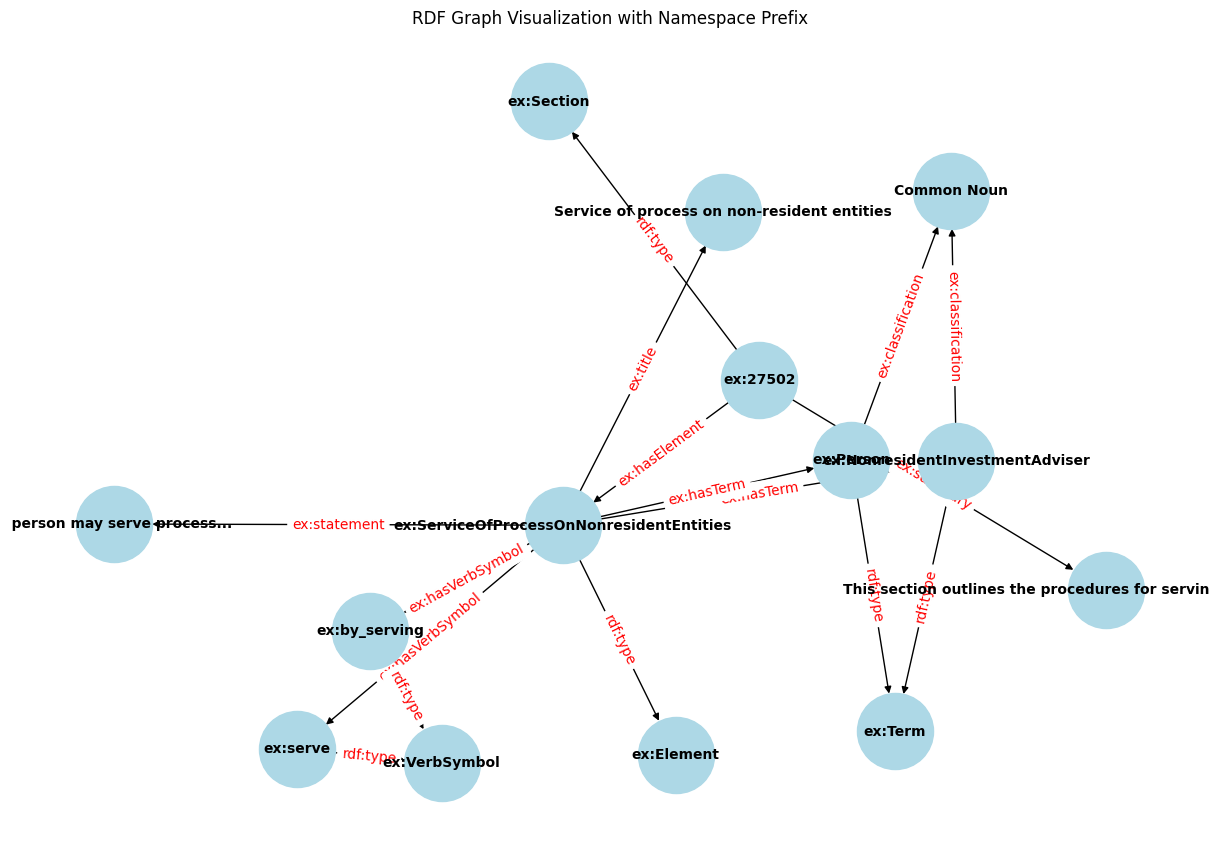

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import rdflib

# Convert RDFLib graph to NetworkX graph
nx_graph = nx.DiGraph()

def shorten_uri(uri):
    return uri.replace(str(EX), f"{namespace_prefix}:")

for s, p, o in g:
    nx_graph.add_edge(shorten_uri(s), shorten_uri(o), label=shorten_uri(p))

nx_graph = nx.DiGraph()

def shorten_uri(uri):
    if str(uri).startswith(str(EX)):
        return uri.replace(str(EX), f"{namespace_prefix}:")
    elif str(uri) == str(rdflib.RDF.type):
        return "rdf:type"
    return uri

for s, p, o in g:
    nx_graph.add_edge(shorten_uri(s), shorten_uri(o), label=shorten_uri(p))

# Draw the graph
pos = nx.spring_layout(nx_graph, seed=42, k=0.5)  # Increase k to spread nodes further apart
edge_labels = nx.get_edge_attributes(nx_graph, 'label')

plt.figure(figsize=(12, 8))
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red')
plt.title("RDF Graph Visualization with Namespace Prefix")

# Save the graph as an image file
plt.savefig("rdf_graph.png", format="png")

# Show the plot
plt.show()
